In [7]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils

from skimage import io, transform

import os

#%load_ext tensorboard.notebook
#tensorboard --logdir

In [8]:
# Preprocessing.
if False:
    # Remove all people without pictures.
    df_copy = pd.DataFrame().reindex_like(attributes)
    print(len(df_copy))
    df_copy = df_copy.iloc[0:0]
    print(len(df_copy))
    attributes = pd.read_csv("person.csv", sep=';')
    original_attributes = attributes.copy()

    df_copy = pd.DataFrame().reindex_like(attributes)
    df_copy = df_copy.iloc[0:0]
    counter_no_img = 0

    for index, row in attributes.iterrows():
            id_nr = row['id'] + '.jpg'
            img_path = 'front/front/'
            img = mpimg.imread(img_path + id_nr)

            # histogram, bin_edges = np.histogram(img[:, :, 0], bins=256, range=(0, 256))
            # occurrences = np.count_nonzero(histogram == 0)
            # print(occurrences)
            if index % 2500 == 0:
                print(index, counter_no_img)
            if img.shape[2] == 4: # occurrences>200:
                counter_no_img += 1
                df_copy = df_copy.append(original_attributes.iloc[index])
                attributes = attributes.drop(original_attributes.index[index])

    print(len(attributes))

    df_copy.to_csv("attributesPersonsNoImages.csv", index=False)
    attributes.to_csv("attributesPersonsWithImages.csv", index=False)
    
    train_set = persons_attributes.sample(frac=0.85, random_state=3072021)
    test_set = persons_attributes.drop(train_set.index)

    train_set.to_csv("trainSet.csv", index=False)
    test_set.to_csv("testSet.csv", index=False)

persons_with_no_images = pd.read_csv("attributesPersonsNoImages.csv")
persons_attributes = pd.read_csv("attributesPersonsWithImages.csv")

train_set = pd.read_csv("trainSet.csv")
test_set = pd.read_csv("testSet.csv")

In [9]:
class FaceDataset(Dataset):
    """Face dataset."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied.
                on a sample.
        """
        self.attributes = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.attributes)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.attributes.loc[idx, 'id'] + '.jpg')
        image = Image.open(img_name)
        
        # Create a dictionary with the properties of the image
        # and the image itself.
        sample = self.attributes.iloc[0, :].to_dict()
        sample['image'] = image
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        
        return sample

In [10]:
# Define more abstract U-Net classes
# Source: https://github.com/milesial/Pytorch-UNet/blob/6aa14cbbc445672d97190fec06d5568a0a004740/unet/unet_parts.py#L28

# Constructed according to typical behaviour in the U-Net
# where two convolutions with kernel=3 are stacked.
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        # In U-net we do two convolutions, but keep the channels the same
        # (so out_channels twice).
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            )
    
    def forward(self, x):
        return self.double_conv(x)

# Constructed according to typical behaviour in the U-Net
# where we downsample, immediately followed by doubling the
# channels by 2.
class Down(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.maxpool_conv(x)

# Does the reverse of the Down class, since we want
# to reconstruct the image.
class Up(nn.Module):
    
    def __init__(self, in_channels, out_channels, bilinear):
        super().__init__()
        
        # If bilinear, use the normal convolution to reduce the number of channels.
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
            # Note that here we don't have the halve the in_channels to account for the concatenation.
            # This is because this is already compensated for in the UNet itself. You could see it as
            # the previous layer taking this already into account and therefore outputting half the
            # channel size for the upsampling method.
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            
            # Note that switching to in_channels again (as opposed to in_channels // 2),
            # makes sense because this includes the added features from the encoding part,
            # which doubles the in_channels size.
            self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Input is BCHW (batch, channel, height, width)
        # In order to account for the correct height and width size
        # when concatenating, we have to pad x1 to match x2.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)

In [11]:
# Define a convolutional neural network
class UNet(nn.Module):
    def __init__(self, bilinear):
        super(UNet, self).__init__()
        
        self.n_channels = 3
        self.bilinear = bilinear
        
        factor = 2 if bilinear else 1

        self.inc = DoubleConv(self.n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, self.n_channels, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

/home/nathan/.local/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


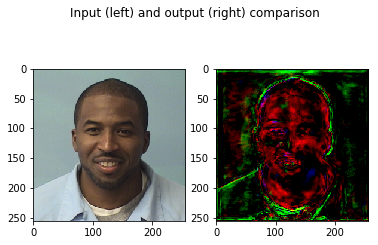

[1,     1] loss: 0.861


KeyboardInterrupt: 

In [12]:
train_set = FaceDataset(csv_file="trainSet.csv",
                        root_dir='data/front/front',
                        transform=transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor()
                        ]))

test_set = FaceDataset(csv_file="testSet.csv",
                       root_dir='data/front/front',
                       transform=transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor()
                       ]))

dataloader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)

net = UNet(bilinear=True)

criterion = nn.MSELoss() # average loss over the whole reconstructed image.
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Just for testing, to see our data
#dataiter = iter(dataloader)
#images, labels = 
#print(dataiter.next())
#print(labels)

# Train the network
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(dataloader, start=0):
        inputs = data['image']
        labels = data['image']
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        
        # Get output image.
        image_output = outputs[0].detach().numpy().T
        image_output = np.swapaxes(image_output, 0, 1)
        image_input = labels[0].detach().numpy().T
        image_input = np.swapaxes(image_input, 0, 1)
        
        # Plot the input and output next to each other.
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Input (left) and output (right) comparison')
        ax1.imshow(image_input)
        ax2.imshow(image_output)
        plt.show()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        #if i % 2 == 0:    # print every n mini-batches
        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

print('Finished training')